# # Full Cross-Validation and Final Training Evaluation Notebook
# 
# This notebook performs graph neural network (GNN)-based classification or regression using a custom Message Passing Neural Network (MPNN) architecture. It supports training with 5-fold cross-validation and then retrains a final model on combined data using early stopping. Performance is evaluated on a held-out test set.
# 
# ## 🧭 Workflow Overview
# 
# ### Step 1. Imports and Setup
# - Load libraries including PyTorch, PyTorch Geometric, and scikit-learn.
# - Configure plotting and file management tools.
# 
# ### Step 2. Task and Reproducibility Setup
# - Set task: `task = "classification"` or `"regression"`.
# - Configure reproducibility with a fixed random seed for reproducibility
# - Define class names if applicable and set up result directories.
# 
# ### Step 3. Model Definition
# - Define an MPNN layer and model using PyTorch Geometric.
# - The model takes node and edge features and outputs class scores or scalar predictions.
# 
# ### Step 4. Evaluation Helper Function
# - Implements an `evaluate(model, loader)` function to return model outputs and ground truths.
# 
# ### Step 5. Input Dimensions and Device Setup
# - Determine input feature dimensions from dataset.
# - Detect and assign appropriate device (CPU or GPU).
# 
# ### Step 6. Cross-Validation Training and Evaluation
# - Train the model across 5 folds using pre-split datasets from ../4_train_test_split/5fold_cv/{task}/
.
# - Log metrics per fold:
#   - **Classification**: accuracy, precision, recall, F1, AUC-ROC
#   - **Regression**: MAE, MSE, RMSE, R²
# - Save all results to CSV.
# 
# ### Step 7. Final Model Training and Test Evaluation
# - Merge all training and validation folds.
# - Reserve a small stratified/random validation split.
# - Train model with:
#   - **Early stopping** (based on validation loss)
#   - **Learning rate scheduler**
#   - **Model checkpointing** (saves best model)
# - Evaluate on the held-out test set and save predictions + plots.
# 
# ### Step 8. Cross-Validation Results Visualization
# - Plot fold-wise bar charts for key metrics.
# - Display mean and standard deviation summary.
# 
# ### Step 9. Interpreting Final Model AUC-ROC and Confusion Matrix
# - Provide interpretation of model behavior:
#   - AUC-ROC curve → how well the model separates classes
#   - Confusion matrix → where the model gets confused
# - Identify any class-specific issues 
#
# ---
#
# ## 🛠 Parameters That Can Be optimized/tuned
#
# - **Hidden dimension** of MPNN: `hidden_dim`
# - **Learning rate**: `lr` in `Adam` optimizer
# - **Batch size**: affects convergence speed and generalization
# - **Early stopping patience**: number of epochs without improvement
# - **Scheduler factor/patience**: reduce LR when plateauing
# - **Model depth**: number of MPNN layers
# - **Number of epochs**: max training rounds
# - **Loss function**: CrossEntropy vs. MSE depending on task
# - **Stratified vs. random validation split**

# ---
#
# ✅ This notebook can be extended with additional model types (e.g., GAT, GIN), more complex featurization, or hyperparameter search.


## 1. Imports and Setup

In [197]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [198]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#task = "classification"  # or "regression"
task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}

base_path = f"../4_train_test_split/5fold_cv/{task}/"
results_dir = f"MPNN_results/{task}/"
os.makedirs(results_dir, exist_ok=True)

## 3a. Model Definition

In [ ]:
class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        self.edge_proj = Linear(edge_dim, out_channels)
        self.msg_lin = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.lin(x)
        edge_attr = self.edge_proj(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return self.msg_lin(x_j + edge_attr)

    def update(self, aggr_out):
        return F.relu(aggr_out)

class MPNN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim):
        super().__init__()
        self.mp1 = MPNNLayer(input_dim, hidden_dim, edge_dim)
        self.mp2 = MPNNLayer(hidden_dim, hidden_dim, edge_dim)
        self.out = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.mp1(x, edge_index, edge_attr)
        x = self.mp2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = global_mean_pool(x, data.batch)
        return self.out(x)

## 3b. Define MPNN Layer and MPNN Model with Dropout Support
# Enhanced MPNN model with dropout layers after each message-passing block to reduce overfitting.

In [200]:
class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        self.edge_proj = Linear(edge_dim, out_channels)
        self.msg_lin = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.lin(x)
        edge_attr = self.edge_proj(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return self.msg_lin(x_j + edge_attr)

    def update(self, aggr_out):
        return F.relu(aggr_out)

class MPNN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim, dropout=0.0):
        super().__init__()
        self.dropout = dropout
        self.mp1 = MPNNLayer(input_dim, hidden_dim, edge_dim)
        self.mp2 = MPNNLayer(hidden_dim, hidden_dim, edge_dim)
        self.out = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.mp1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.mp2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, data.batch)
        return self.out(x)


## 4. Evaluation Helper Function

In [201]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [202]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 6a. Cross-Validation Training and Evaluation

In [148]:
fold_metrics = []
for fold in range(5):
    print(f"\n🔁 Fold {fold+1}/5")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = MPNN(input_dim, edge_dim, hidden_dim=256, output_dim=output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)

    for epoch in range(1, 100):
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.cross_entropy(out, batch.y.long()) if task == "classification" else F.mse_loss(out.squeeze(), batch.y)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

    outputs, targets = evaluate(model, val_loader)

    if task == "classification":
        y_probs = F.softmax(outputs, dim=1).numpy()
        y_pred = outputs.argmax(dim=1).numpy()
        y_true = targets.numpy().astype(int)
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
        y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
        auc_val = roc_auc_score(y_true_bin, y_probs, multi_class="ovr")
        fold_metrics.append({"fold": fold+1, "accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1, "auc_roc": auc_val})
    else:
        y_true = targets.numpy()
        y_pred = outputs.squeeze().numpy()
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        fold_metrics.append({"fold": fold+1, "mae": mae, "mse": mse, "rmse": rmse, "r2": r2})
    torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))

cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("\n✅ Cross-validation complete. Mean metrics:")
print(cv_df.mean(numeric_only=True))


🔁 Fold 1/5
Epoch 2 | Loss: 4.0083
Epoch 3 | Loss: 2.5485
Epoch 4 | Loss: 2.1562
Epoch 5 | Loss: 1.2620
Epoch 6 | Loss: 0.5033
Epoch 7 | Loss: 1.0783
Epoch 8 | Loss: 2.0172
Epoch 9 | Loss: 0.5720
Epoch 10 | Loss: 0.7806
Epoch 11 | Loss: 0.6302
Epoch 12 | Loss: 0.6399
Epoch 13 | Loss: 2.5040
Epoch 14 | Loss: 0.6841
Epoch 15 | Loss: 1.3320
Epoch 16 | Loss: 0.8516
Epoch 17 | Loss: 0.5590
Epoch 18 | Loss: 1.2700
Epoch 19 | Loss: 0.9523
Epoch 20 | Loss: 0.8442
Epoch 21 | Loss: 0.9041
Epoch 22 | Loss: 1.1442
Epoch 23 | Loss: 0.9601
Epoch 24 | Loss: 0.6522
Epoch 25 | Loss: 0.8311
Epoch 26 | Loss: 1.5128
Epoch 27 | Loss: 1.4751
Epoch 28 | Loss: 2.4714
Epoch 29 | Loss: 1.1371
Epoch 30 | Loss: 0.7456
Epoch 31 | Loss: 0.4583
Epoch 32 | Loss: 1.9617
Epoch 33 | Loss: 0.6510
Epoch 34 | Loss: 1.0678
Epoch 35 | Loss: 1.6163
Epoch 36 | Loss: 1.5936
Epoch 37 | Loss: 0.9754
Epoch 38 | Loss: 0.3221
Epoch 39 | Loss: 0.6435
Epoch 40 | Loss: 0.7804
Epoch 41 | Loss: 1.1300
Epoch 42 | Loss: 1.8349
Epoch 43 | L

# ## 6b: Hyperparameter Sweep over Hidden Dimension and Dropout
# Loop over combinations of `hidden_dim` and `dropout` and report the average R2 across 5 folds.

In [162]:
hidden_dims = [64, 128, 256]
dropouts = [0.0, 0.2, 0.4]

results = []

for hd in hidden_dims:
    for dp in dropouts:
        print(f"\n🔧 Training with hidden_dim={hd}, dropout={dp}")
        fold_metrics = []

        for fold in range(5):
            train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
            val_data = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

            model = MPNN(input_dim, edge_dim, hidden_dim=hd, output_dim=output_dim, dropout=dp).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=32)

            for epoch in range(1, 100):
                model.train()
                for batch in train_loader:
                    batch = batch.to(device)
                    optimizer.zero_grad()
                    out = model(batch)
                    loss = F.mse_loss(out.squeeze(), batch.y)
                    loss.backward()
                    optimizer.step()

            outputs, targets = evaluate(model, val_loader)
            y_true = targets.numpy()
            y_pred = outputs.squeeze().numpy()
            r2 = r2_score(y_true, y_pred)
            fold_metrics.append(r2)

        mean_r2 = np.mean(fold_metrics)
        std_r2 = np.std(fold_metrics)
        results.append((hd, dp, mean_r2, std_r2))
        print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")


🔧 Training with hidden_dim=64, dropout=0.0
📊 R²: 0.2026 ± 0.0405

🔧 Training with hidden_dim=64, dropout=0.2
📊 R²: 0.2771 ± 0.0613

🔧 Training with hidden_dim=64, dropout=0.4
📊 R²: 0.2827 ± 0.1009

🔧 Training with hidden_dim=128, dropout=0.0
📊 R²: 0.2987 ± 0.0312

🔧 Training with hidden_dim=128, dropout=0.2
📊 R²: 0.2828 ± 0.1124

🔧 Training with hidden_dim=128, dropout=0.4
📊 R²: 0.3369 ± 0.0747

🔧 Training with hidden_dim=256, dropout=0.0
📊 R²: 0.3043 ± 0.1230

🔧 Training with hidden_dim=256, dropout=0.2
📊 R²: 0.2898 ± 0.1181

🔧 Training with hidden_dim=256, dropout=0.4
📊 R²: 0.1517 ± 0.1308


# ## 6c: Display Results Table Sorted by Mean R²

In [157]:
sweep_df = pd.DataFrame(results, columns=["hidden_dim", "dropout", "mean_r2", "std_r2"])
display(sweep_df.sort_values("mean_r2", ascending=False))

,hidden_dim,dropout,mean_r2,std_r2
8,256,0.4,0.272757,0.127402
0,64,0.0,0.264280,0.080144
1,64,0.2,0.257058,0.045228
4,128,0.2,0.254274,0.058720
5,128,0.4,0.244460,0.044319
2,64,0.4,0.218171,0.085653
3,128,0.0,0.208034,0.114516
7,256,0.2,0.185880,0.111337
6,256,0.0,0.079241,0.152689


# ## 8. Cross-Validation Results Visualization

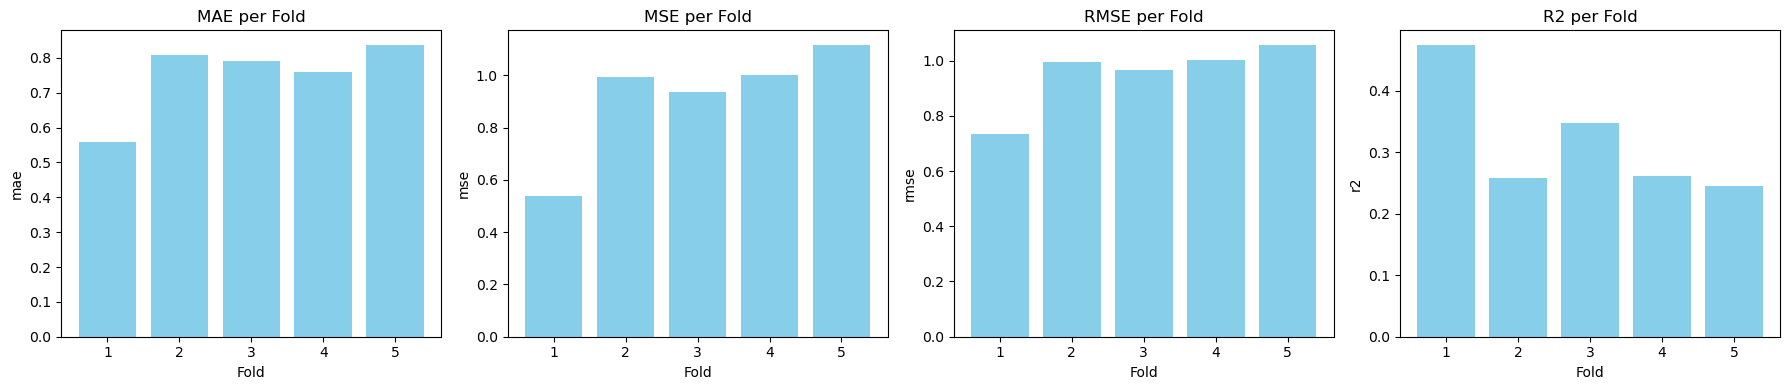


📊 Mean ± Std for Cross-Validation Metrics:


,mean,std
mae,0.7509,0.1107
mse,0.9169,0.2216
rmse,0.9509,0.1257
r2,0.3177,0.0966


In [158]:
if task == "classification":
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
else:  # regression
    metrics = ['mae', 'mse', 'rmse', 'r2']

cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))

fig, axs = plt.subplots(1, len(metrics), figsize=(18, 4))
for i, metric in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

summary_stats = cv_df[metrics].agg(['mean', 'std']).T
print("\n📊 Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))


# ## 9. Ensemble Averaging from Cross-Validation Models
# 
# This cell loads the trained model weights from each fold (if saved), applies them to the test set, and averages the predictions across all folds.
# Useful for boosting robustness by combining the knowledge of all 5 CV models.


📊 Ensemble Regression Metrics:
MAE: 0.7474, MSE: 0.9072, RMSE: 0.9525, R2: 0.3170


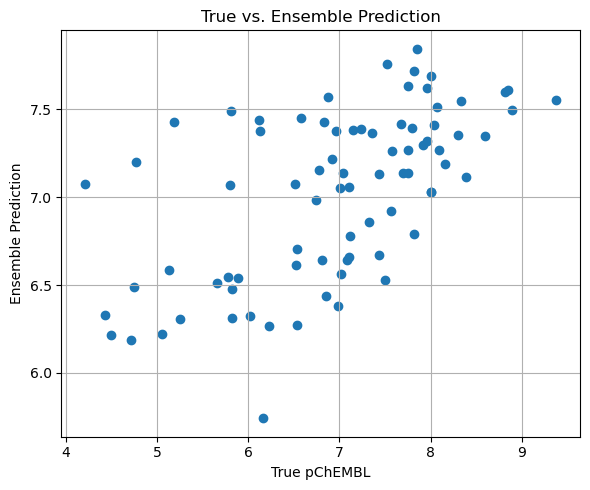

✅ Ensemble regression predictions and plot saved.


In [161]:
# %% [markdown]
# ## 12. Ensemble Averaging from Cross-Validation Models
# 
# This cell loads the trained model weights from each fold (after training), applies them to the test set, and averages the predictions across all folds.
# Useful for boosting robustness by combining the knowledge of all 5 CV models.

# %%
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Make sure model config matches task
output_dim = num_classes if task == "classification" else 1

for fold in range(5):
    model = MPNN(input_dim, edge_dim, hidden_dim=256, output_dim=output_dim, dropout=0.4).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()

    outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            outputs.append(out.cpu())

    all_outputs = torch.cat(outputs, dim=0)
    ensemble_preds.append(all_outputs)

# Average predictions
avg_output = torch.stack(ensemble_preds).mean(dim=0)

if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
    pd.DataFrame({"True": true_labels, "Pred": final_pred}).to_csv(
        os.path.join(results_dir, "ensemble_predictions.csv"), index=False)

    print("\n✅ Ensemble classification predictions saved.")

elif task == "regression":
    final_pred = avg_output.squeeze().numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy()
    pd.DataFrame({"True": true_labels, "Pred": final_pred}).to_csv(
        os.path.join(results_dir, "ensemble_predictions.csv"), index=False)

    # Evaluate ensemble performance
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    import matplotlib.pyplot as plt

    mae = mean_absolute_error(true_labels, final_pred)
    mse = mean_squared_error(true_labels, final_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, final_pred)

    print("\n📊 Ensemble Regression Metrics:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    # Save metrics to CSV
    pd.DataFrame([{
        "mae": mae, "mse": mse, "rmse": rmse, "r2": r2
    }]).to_csv(os.path.join(results_dir, "ensemble_model_metrics.csv"), index=False)

    # Plot True vs Predicted
    plt.figure(figsize=(6, 5))
    plt.scatter(true_labels, final_pred)
    plt.xlabel("True pChEMBL")
    plt.ylabel("Ensemble Prediction")
    plt.grid(True)
    plt.title("True vs. Ensemble Prediction")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "ensemble_true_vs_pred.png"))
    plt.show()

    print("✅ Ensemble regression predictions and plot saved.")


## 10. Final Model Training and Test Evaluation

In [131]:
# Final Training + Evaluation
all_trainval = []
for fold in range(5):
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
    all_trainval.extend(train_data)
    all_trainval.extend(val_data)

test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))

if task == "classification":
    labels = [int(d.y.item()) for d in all_trainval]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
    train_idx, val_idx = next(sss.split(all_trainval, labels))
else:
    train_idx, val_idx = train_test_split(range(len(all_trainval)), test_size=0.1, random_state=seed)

train_split = [all_trainval[i] for i in train_idx]
val_split = [all_trainval[i] for i in val_idx]

model = MPNN(input_dim, edge_dim, hidden_dim=128, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader = DataLoader(val_split, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

best_val_loss = float('inf')
patience_counter = 0
for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.cross_entropy(out, batch.y.long()) if task == "classification" else F.mse_loss(out.squeeze(), batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    outputs, targets = evaluate(model, val_loader)
    val_loss = F.cross_entropy(outputs, targets.long()).item() if task == "classification" else F.mse_loss(outputs.squeeze(), targets).item()
    scheduler.step(val_loss)

    print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(results_dir, "final_model.pt"))
    else:
        patience_counter += 1
        if patience_counter >= 10:
            print("⏹️ Early stopping triggered.")
            break

model.load_state_dict(torch.load(os.path.join(results_dir, "final_model.pt")))
outputs, targets = evaluate(model, test_loader)

if task == "classification":
    y_probs = F.softmax(outputs, dim=1).numpy()
    y_pred = outputs.argmax(dim=1).numpy()
    y_true = targets.numpy().astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    auc_val = roc_auc_score(y_true_bin, y_probs, multi_class="ovr")

    pd.DataFrame([{
        "accuracy": acc, "precision": precision,
        "recall": recall, "f1_score": f1, "auc_roc": auc_val
    }]).to_csv(os.path.join(results_dir, "final_model_metrics.csv"), index=False)

    pd.DataFrame({"True": y_true, "Pred": y_pred}).to_csv(
        os.path.join(results_dir, "final_model_predictions.csv"), index=False)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[i] for i in range(num_classes)])
    disp.plot(cmap="Blues")
    plt.title("Final Model - Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "final_confusion_matrix.png"))
    plt.close()

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7, 5))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Final Model - AUC-ROC")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "final_auc_roc.png"))
    plt.close()
else:
    y_true = targets.numpy()
    y_pred = outputs.squeeze().numpy()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    pd.DataFrame([{
        "mae": mae, "mse": mse, "rmse": rmse, "r2": r2
    }]).to_csv(os.path.join(results_dir, "final_model_metrics.csv"), index=False)

    pd.DataFrame({"True": y_true, "Pred": y_pred}).to_csv(
        os.path.join(results_dir, "final_model_predictions.csv"), index=False)

    print("\n📊 Final Regression Metrics:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train Loss: 15.8012 | Val Loss: 0.8626
Epoch 002 | Train Loss: 1.0133 | Val Loss: 0.8146
Epoch 003 | Train Loss: 1.0067 | Val Loss: 0.7948
Epoch 004 | Train Loss: 1.0017 | Val Loss: 0.7959
Epoch 005 | Train Loss: 1.0045 | Val Loss: 0.7985
Epoch 006 | Train Loss: 0.9821 | Val Loss: 0.8032
Epoch 007 | Train Loss: 0.9797 | Val Loss: 0.8026
Epoch 008 | Train Loss: 0.9698 | Val Loss: 0.7945
Epoch 009 | Train Loss: 0.9616 | Val Loss: 0.7959
Epoch 010 | Train Loss: 0.9572 | Val Loss: 0.8041
Epoch 011 | Train Loss: 0.9678 | Val Loss: 0.7912
Epoch 012 | Train Loss: 0.9629 | Val Loss: 0.8238
Epoch 013 | Train Loss: 0.9585 | Val Loss: 0.7872
Epoch 014 | Train Loss: 0.9764 | Val Loss: 0.8034
Epoch 015 | Train Loss: 0.9576 | Val Loss: 0.7880
Epoch 016 | Train Loss: 0.9373 | Val Loss: 0.7828
Epoch 017 | Train Loss: 0.9667 | Val Loss: 0.7794
Epoch 018 | Train Loss: 0.9241 | Val Loss: 0.7848
Epoch 019 | Train Loss: 0.9341 | Val Loss: 0.7722
Epoch 020 | Train Loss: 0.9330 | Val Loss: 0.7953

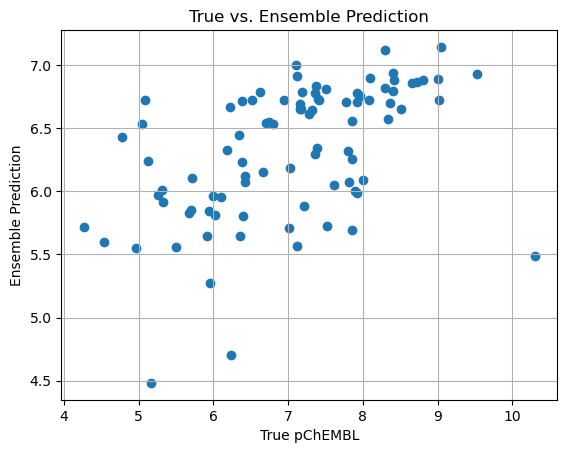

MAE: 0.7473914
R²:  0.3169957399368286
Min pred: 5.742435 Max pred: 7.844129
torch.Size([8])
tensor([8.5700, 5.1100, 8.4400, 5.8600, 6.8000])


In [163]:
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred)
plt.xlabel("True pChEMBL")
plt.ylabel("Ensemble Prediction")
plt.grid(True)
plt.title("True vs. Ensemble Prediction")
plt.show()

from sklearn.metrics import mean_absolute_error, r2_score
print("MAE:", mean_absolute_error(true_labels, final_pred))
print("R²: ", r2_score(true_labels, final_pred))
print("Min pred:", final_pred.min(), "Max pred:", final_pred.max())
F.mse_loss(out.squeeze(), batch.y)
print(batch.y.shape)  # should be [batch_size]
print(batch.y[:5])  # Should be floats like 5.1, 6.7, etc.



# ## 12. Hyperparameter Tuning with Optuna (Optional)
# 
# This step demonstrates how to use [Optuna](https://optuna.org/) to optimize hyperparameters such as hidden layer size, learning rate, and dropout.
# Optuna uses intelligent sampling to efficiently explore hyperparameter space.
#
# Skip this step if you're not performing hyperparameter tuning.

# %%
# Uncomment and install Optuna if needed

# ## 13. Interpreting Final Model AUC-ROC and Confusion Matrix
# 
# ### 📈 AUC-ROC Plot
# - Shows the model's ability to separate each class (Low, Medium, High) from the others.
# - **AUC closer to 1.0 means better separability.**
# 
# **Interpretation Example**:
# - **Low (AUC = 0.91)** →  good at separating the low class (based on predicted probabilities, but fails to classify it correctly- likely due to few low examples).
# - **Medium (AUC = 0.69)** → Weak: model struggles to separate 'Medium'.
# - **High (AUC = 0.81)** → Good: model performs well for 'High' class.
# 
# ---
# 
# ### 🔢 Confusion Matrix
# - Rows = true labels, Columns = predicted labels.
# - Diagonal cells = correct predictions.
# - Off-diagonal cells = mistakes.
# 
# **Sample interpretation**:
# - "Medium" is often confused with "High" (11 times) and occasionally with "Low" (2 times).
# - "High" is predicted well, but 9 are misclassified as "Medium".
# - "Low" is mostly confused with "Medium" — never with "High" (which is good).
# 
# This pattern suggests the model mostly makes **nearby mistakes** (e.g., Medium ↔ High), which is expected in ordered classification problems.
# 
# ---
# 



# # Steps 3–7: Hyperparameter Tuning, Retraining, and Evaluation
# This notebook covers the core stages in training and evaluating a GNN model using 5-fold CV and ensemble averaging.


## Step 3: Cross-Validation Training with Hyperparameter Sweep


# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [ ]:
# Hyperparameter grids
hidden_dims = [64, 128, 256]
dropouts = [0.0, 0.2, 0.4]
lrs = [1e-3, 5e-4, 1e-4]

results = []
print("Starting hyperparameter sweep over hidden_dim, dropout, and learning rate")
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            fold_metrics = []
            for fold in range(5):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

                # Initialize model and optimizer
                model = MPNN(input_dim, edge_dim,
                             hidden_dim=hd,
                             output_dim=output_dim,
                             dropout=dp).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Data loaders
                train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
                val_loader   = DataLoader(val_data,   batch_size=32)

                # Training loop
                for epoch in range(1, 51):
                    model.train()
                    for batch in train_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        out = model(batch)
                        loss = F.mse_loss(out.squeeze(), batch.y)
                        loss.backward()
                        optimizer.step()

                # Validation
                preds, trues = evaluate(model, val_loader)
                y_true = trues.numpy()
                y_pred = preds.squeeze().numpy()
                r2 = r2_score(y_true, y_pred)
                fold_metrics.append(r2)

            # Record mean and std
            mean_r2 = np.mean(fold_metrics)
            std_r2  = np.std(fold_metrics)
            results.append((hd, dp, lr, mean_r2, std_r2))
            print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")

# Compile results into DataFrame
sweep_df = pd.DataFrame(results,
                        columns=["hidden_dim", "dropout", "learning_rate", "mean_r2", "std_r2"])
# Display sorted by best performance
display(sweep_df.sort_values("mean_r2", ascending=False))
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print(f"✅ Saved cross‑validation summary to {results_dir}/crossval_summary.csv")


Starting hyperparameter sweep over hidden_dim, dropout, and learning rate
Config: hidden_dim=64, dropout=0.0, lr=0.001
📊 R²: 0.2643 ± 0.0801
Config: hidden_dim=64, dropout=0.0, lr=0.0005
📊 R²: 0.2620 ± 0.0878
Config: hidden_dim=64, dropout=0.0, lr=0.0001
📊 R²: 0.2720 ± 0.0753
Config: hidden_dim=64, dropout=0.2, lr=0.001
📊 R²: 0.2527 ± 0.1094
Config: hidden_dim=64, dropout=0.2, lr=0.0005
📊 R²: 0.2657 ± 0.0681
Config: hidden_dim=64, dropout=0.2, lr=0.0001
📊 R²: 0.2749 ± 0.0811
Config: hidden_dim=64, dropout=0.4, lr=0.001
📊 R²: 0.1939 ± 0.2187
Config: hidden_dim=64, dropout=0.4, lr=0.0005
📊 R²: 0.1711 ± 0.1419
Config: hidden_dim=64, dropout=0.4, lr=0.0001
📊 R²: 0.2724 ± 0.0743
Config: hidden_dim=128, dropout=0.0, lr=0.001
📊 R²: 0.2321 ± 0.1495
Config: hidden_dim=128, dropout=0.0, lr=0.0005
📊 R²: 0.2815 ± 0.0951
Config: hidden_dim=128, dropout=0.0, lr=0.0001
📊 R²: 0.2792 ± 0.0856
Config: hidden_dim=128, dropout=0.2, lr=0.001
📊 R²: 0.2146 ± 0.2284
Config: hidden_dim=128, dropout=0.2, lr=0.0

,hidden_dim,dropout,learning_rate,mean_r2,std_r2
24,256,0.4,0.0010,0.307898,0.081122
13,128,0.2,0.0005,0.299799,0.074944
23,256,0.2,0.0001,0.291137,0.060578
15,128,0.4,0.0010,0.289165,0.072056
22,256,0.2,0.0005,0.286770,0.043435
10,128,0.0,0.0005,0.281521,0.095120
11,128,0.0,0.0001,0.279165,0.085618
14,128,0.2,0.0001,0.279000,0.065247
5,64,0.2,0.0001,0.274871,0.081125
20,256,0.0,0.0001,0.274249,0.079073


In [220]:
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print(f"✅ Saved cross‑validation summary to {results_dir}/crossval_summary.csv")


✅ Saved cross‑validation summary to MPNN_results/regression//crossval_summary.csv


In [221]:

# %%
best_hidden_dim = 256
best_dropout = 0.4
best_lr = 0.001

# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [ ]:
# %%
for fold in range(5):
    print(f"\n🔁 Re-training Fold {fold+1}/5 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = MPNN(input_dim, edge_dim, hidden_dim=best_hidden_dim, output_dim=output_dim, dropout=best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, 100):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out.squeeze(), batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        outputs, targets = evaluate(model, val_loader)
        val_loss = F.mse_loss(outputs.squeeze(), targets).item()

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print("⏹️ Early stopping triggered.")
                break




🔁 Re-training Fold 1/5 with best hyperparameters
Epoch 001 | Train Loss: 9.5959 | Val Loss: 2.0818
Epoch 002 | Train Loss: 1.9556 | Val Loss: 0.6773
Epoch 003 | Train Loss: 1.2383 | Val Loss: 0.6352
Epoch 004 | Train Loss: 1.1524 | Val Loss: 0.6286
Epoch 005 | Train Loss: 1.2387 | Val Loss: 0.6208
Epoch 006 | Train Loss: 1.1400 | Val Loss: 0.6928
Epoch 007 | Train Loss: 1.1587 | Val Loss: 0.6149
Epoch 008 | Train Loss: 1.1115 | Val Loss: 0.6194
Epoch 009 | Train Loss: 1.2190 | Val Loss: 0.6145
Epoch 010 | Train Loss: 1.1690 | Val Loss: 0.7436
Epoch 011 | Train Loss: 1.2476 | Val Loss: 0.7693
Epoch 012 | Train Loss: 1.2557 | Val Loss: 0.7698
Epoch 013 | Train Loss: 1.2254 | Val Loss: 0.6093
Epoch 014 | Train Loss: 1.2483 | Val Loss: 0.6156
Epoch 015 | Train Loss: 1.0783 | Val Loss: 0.6376
Epoch 016 | Train Loss: 1.3043 | Val Loss: 0.6688
Epoch 017 | Train Loss: 1.2875 | Val Loss: 0.6455
Epoch 018 | Train Loss: 1.3859 | Val Loss: 0.8610
Epoch 019 | Train Loss: 1.7246 | Val Loss: 0.6716


## Step 5b: Visualize Cross-Validation Results
# This section plots per-fold metrics from the cross-validation summary to assess stability across folds.


KeyError: 'fold'

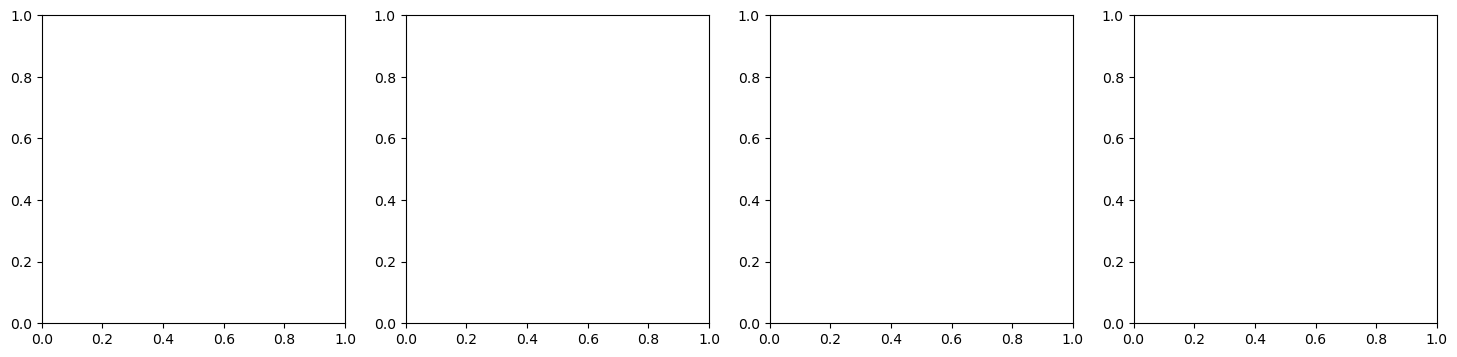

In [219]:
if task == "classification":
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
else:  # regression
    metrics = ['mae', 'mse', 'rmse', 'r2']
# %%
# Load CV summary
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))

# Select metrics based on task
task_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc'] if task == 'classification' else ['mae', 'mse', 'rmse', 'r2']

# Plot bar charts per fold
fig, axs = plt.subplots(1, len(task_metrics), figsize=(18, 4))
for i, metric in enumerate(task_metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

# Display mean ± std
summary_stats = cv_df[task_metrics].agg(['mean', 'std']).T
print("Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))

# ## Step 6a: Ensemble Averaging from Cross-Validation Models

In [222]:
# Load test data
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Ensure model configuration matches
output_dim = num_classes if task == "classification" else 1

# Collect predictions from each fold model
for fold in range(5):
    model = MPNN(input_dim, edge_dim, hidden_dim=best_hidden_dim, output_dim=output_dim, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()
    fold_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            fold_outputs.append(out.cpu())
    ensemble_preds.append(torch.cat(fold_outputs, dim=0))

# Average predictions across folds
avg_output = torch.stack(ensemble_preds).mean(dim=0)

# Prepare final predictions and true labels
if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
else:
    final_pred = avg_output.squeeze().numpy()
    true_value = torch.cat([data.y for data in test_data]).numpy()

print(f"✅ Ensemble predictions ready: shape {final_pred.shape}")

✅ Ensemble predictions ready: shape (80,)


# ## Step 6b: Ensemble Evaluation & Visualization


Ensemble: MAE=0.786, RMSE=0.983, R2=0.272


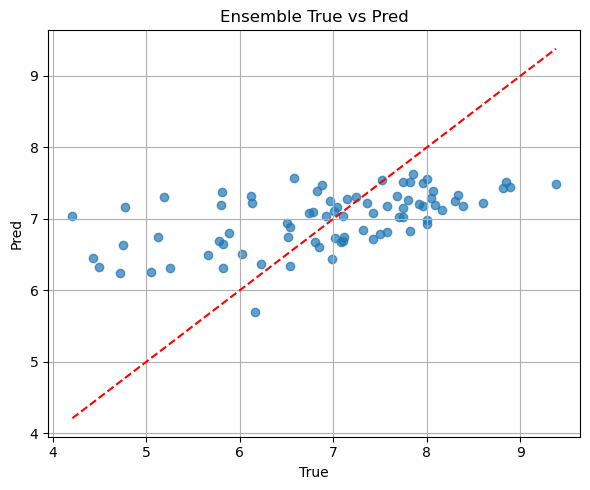

In [223]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
mae = mean_absolute_error(true_value, final_pred)
mse = mean_squared_error  (true_value, final_pred)
rmse= np.sqrt(mse)
r2  = r2_score           (true_value, final_pred)
print(f"Ensemble: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
plt.figure(figsize=(6,5)); plt.scatter(true_value,final_pred,alpha=0.7)
plt.plot([true_value.min(),true_value.max()],[true_value.min(),true_value.max()], 'r--'); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Ensemble True vs Pred"); plt.grid(True); plt.tight_layout(); plt.show()


# ## Step 7: Final Model Training on Combined Data & Test Evaluation


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 | Train 2.6383 | Val 0.8345
Epoch 02 | Train 1.0867 | Val 0.8507
Epoch 03 | Train 1.0685 | Val 1.1212
Epoch 04 | Train 1.0951 | Val 0.9653
Epoch 05 | Train 1.1139 | Val 1.0248
Epoch 06 | Train 1.1170 | Val 0.7761
Epoch 07 | Train 1.0806 | Val 1.0999
Epoch 08 | Train 1.0465 | Val 0.7472
Epoch 09 | Train 1.0652 | Val 0.7656
Epoch 10 | Train 1.2027 | Val 1.0557
Epoch 11 | Train 0.9890 | Val 0.7543
Epoch 12 | Train 1.0269 | Val 0.7997
Epoch 13 | Train 0.9624 | Val 1.1722
Epoch 14 | Train 1.0560 | Val 0.7600
Epoch 15 | Train 1.0514 | Val 0.7684
Epoch 16 | Train 0.9559 | Val 1.1936
Epoch 17 | Train 0.9564 | Val 0.7782
Epoch 18 | Train 0.9951 | Val 0.7294
Epoch 19 | Train 0.9799 | Val 0.7456
Epoch 20 | Train 1.0125 | Val 0.8608
Epoch 21 | Train 0.9507 | Val 0.7771
Epoch 22 | Train 0.9062 | Val 0.7507
Epoch 23 | Train 0.8997 | Val 0.8416
Epoch 24 | Train 0.9636 | Val 0.7332
Epoch 25 | Train 0.9397 | Val 0.7671
Epoch 26 | Train 0.9106 | Val 0.7301
Epoch 27 | Train 0.9144 | Val 0.7627
E

,metric,ensemble,final
0,MAE,0.785776,0.722072
1,RMSE,0.983218,0.936037
2,R2,0.272208,0.340379


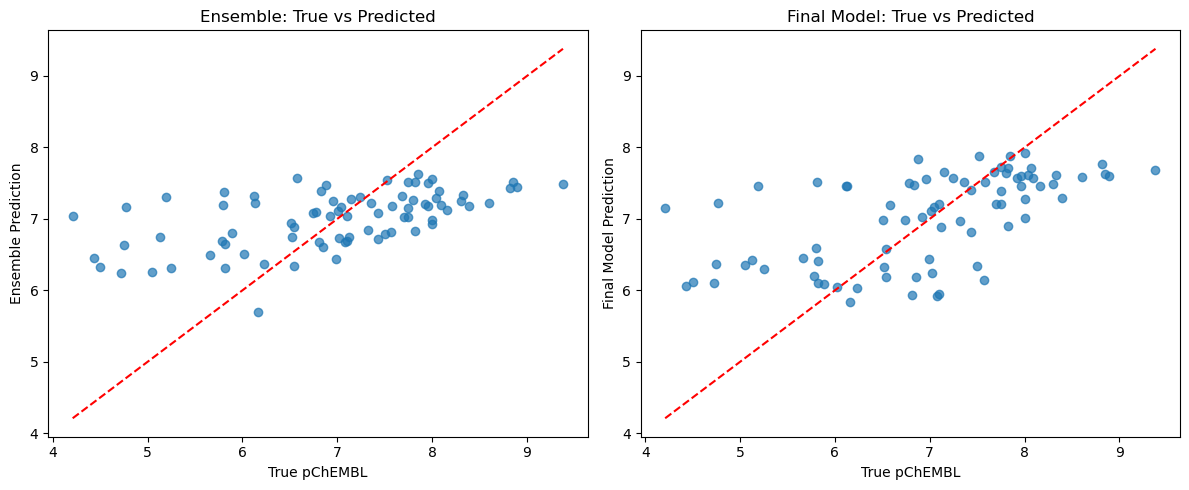

In [224]:
all_data=[]
for fold in range(5):
    all_data += torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# Split off small validation for early stopping
tidx, vidx = train_test_split(range(len(all_data)), test_size=0.1, random_state=seed)
train_split=[all_data[i] for i in tidx]; val_split=[all_data[i] for i in vidx]
train_loader=DataLoader(train_split,batch_size=32,shuffle=True)
val_loader  =DataLoader(val_split,  batch_size=32)
model=MPNN(input_dim,edge_dim,hidden_dim=best_hidden_dim,output_dim=output_dim,dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=5,factor=0.5,verbose=True)
best_val = float('inf')
pt = 0
for epoch in range(1,100):
    model.train(); tot=0
    for b in train_loader: b=b.to(device); opt.zero_grad(); o=model(b); l=F.mse_loss(o.squeeze(),b.y); l.backward(); opt.step(); tot+=l.item()
    preds,trues=evaluate(model,val_loader); vloss=F.mse_loss(preds.squeeze(),trues).item()
    scheduler.step(vloss); print(f"Epoch {epoch:02d} | Train {tot/len(train_loader):.4f} | Val {vloss:.4f}")
    if vloss<best_val: best_val=vloss; pt=0; torch.save(model.state_dict(),os.path.join(results_dir,"final_model.pt"))
    else: pt+=1; 
    if pt>=10: 
        print("⏹️ Early stopping"); 
        break
# Load best and evaluate on test
model.load_state_dict(torch.load(os.path.join(results_dir,"final_model.pt")))
out,tru=evaluate(model,DataLoader(test_data,batch_size=32))
pred_final=out.squeeze().numpy(); true_final=tru.numpy()
mae_f=mean_absolute_error(true_final,pred_final); mse_f=mean_squared_error(true_final,pred_final)
rmse_f=np.sqrt(mse_f); r2_f=r2_score(true_final,pred_final)
print(f"Final: MAE={mae_f:.3f}, RMSE={rmse_f:.3f}, R2={r2_f:.3f}")
# Compare
comp = pd.DataFrame({ 'metric':['MAE','RMSE','R2'], 'ensemble':[mae, rmse, r2], 'final':[mae_f, rmse_f, r2_f] })
display(comp)

# Side-by-side scatter plots for Ensemble vs Final Model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Ensemble plot
axes[0].scatter(true_value, final_pred, alpha=0.7)
axes[0].plot([true_value.min(), true_value.max()], [true_value.min(), true_value.max()], 'r--')
axes[0].set_title('Ensemble: True vs Predicted')
axes[0].set_xlabel('True pChEMBL')
axes[0].set_ylabel('Ensemble Prediction')

# Final model plot
axes[1].scatter(true_final, pred_final, alpha=0.7)
axes[1].plot([true_final.min(), true_final.max()], [true_final.min(), true_final.max()], 'r--')
axes[1].set_title('Final Model: True vs Predicted')
axes[1].set_xlabel('True pChEMBL')
axes[1].set_ylabel('Final Model Prediction')

plt.tight_layout()
plt.show()